In [7]:
import numpy as np
import pandas as pd
import random
from itertools import combinations
from itertools import permutations
import math
from scipy.stats import poisson
import matplotlib as plt

# Sources:

- https://en.wikipedia.org/wiki/Mersenne_Twister
- https://github.com/yinengy/Mersenne-Twister-in-Python/blob/master/RandomClass.py
- https://canvas.hu.nl/courses/27428/assignments/168825
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html


# Doel:

Deze opdracht is in meerdere delen opgedeeld:

- Implementeer een pseudo-random number generator
- Simuleer een voetbalcompetitie aan de hand van onderlinge win rates
- Simuleer een voetbalompetitie aan de hand van gemiddelde doelsaldo's van team
- Vergelijk de twee simulaties met elkaar

#  PRNG (Mersenne Twister):

In [2]:
class MT():
    
    def __init__(self, i_seed):
    
        self.w = 32
        self.r = 31
        self.n = 624
        self.m = 397
        self.u = 11
        self.s = 7
        self.t = 15
        self.l = 18
        self.a = 0x9908b0df
        self.b = 0x9d2c5680
        self.c = 0xefc60000
        self.f = 0x6c078965
        self.upper_mask = 0x80000000
        self.lower_mask = 0x7FFFFFFF
        
        self.x = [1 for i in range(self.n)]
        
        self.init_array(i_seed)
        
    def init_array(self,seed):
        
            self.x[0] = seed

            self.index = self.n

            for i in range(1, self.n):

                self.x[i] = self.f * (self.x[i-1] ^ (self.x[i-1] >> (self.w-2))) + i & 0xffffffff
        
        
    def generate_numbers(self):
        for i in range(self.n):
            y = (self.x[i] & self.upper_mask) + (self.x[(i+1) % self.n] & self.lower_mask)
            
            # shiftright by default
            xA = y >> 1

            # shiftright AND bitwise exclusive OR if y % 2 == 1
            if (y % 2) == 1:
                xA = xA ^ self.a
            
            self.x[i] = self.x[(i + self.m) % self.n] ^ xA
            
        self.index = 0
        
        
    def tempering(self):
        
       
        if self.index >= self.n:
            self.generate_numbers()
        
        y = self.x[self.index]
        y = y ^ (y >> self.u)
        y = y ^ ((y << self.s) & self.b)
        y = y ^ ((y << self.t) & self.c)
        y = y ^ (y >> self.l)
        
        self.index += 1
                
        return y
    
    def random(self):
        # convert to number within domain [0,1>
        
        return self.tempering() / 2**self.w
    
    
    def randint(self, a, b):
        # generate random int within domain [a,b> 
        
        return int(self.random()/(1/(b-a)) + a)
     

# Testing the randomness of the MT class:

In [3]:
# create MT object with seed 5489
mt = MT(5489)

# these results match the results on Canvas
[mt.tempering() for _ in range(10)]

[3499211612,
 581869302,
 3890346734,
 3586334585,
 545404204,
 4161255391,
 3922919429,
 949333985,
 2715962298,
 1323567403]

<AxesSubplot:ylabel='Frequency'>

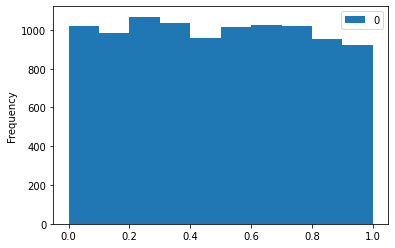

In [8]:
pd.DataFrame([mt.random() for _ in range(10000)]).plot.hist()

In [9]:
from PIL import Image

img = Image.new('1', (200, 200))
pixels = img.load()
for x in range(img.size[0]):
    for y in range(img.size[1]):
        randomNumber = mt.random()
        pixels[x, y] = 0 if randomNumber < 0.5 else 1

img.show()

# Simulating Football Games:

In [10]:
data = {'Ajax':[None,'30/21/49','39/22/39','25/14/61','17/18/65'],
       'Feyenoord':['65/17/18', None, '54/22/24', '37/23/40','20/26/54'],
       'PSV':['54/21/25', '37/24/39', None, '29/24/47', '23/24/53'],
       'FC Utrecht':['74/14/12', '51/22/27', '62/20/18', None, '37/25/38'],
       'Willem II':['78/13/9', '60/21/19', '62/22/16', '52/23/25', None]}
df = pd.DataFrame(data)
df = df.set_index(pd.Series(df.columns))
indices = df.columns
df

,Ajax,Feyenoord,PSV,FC Utrecht,Willem II
Ajax,None,65/17/18,54/21/25,74/14/12,78/13/9
Feyenoord,30/21/49,None,37/24/39,51/22/27,60/21/19
PSV,39/22/39,54/22/24,None,62/20/18,62/22/16
FC Utrecht,25/14/61,37/23/40,29/24/47,None,52/23/25
Willem II,17/18/65,20/26/54,23/24/53,37/25/38,None


In [11]:
def roll(data):
    
    rand = mt.randint(1,100)
    
    data = data.split('/')
    
    
    win_rec = int(data[0])
    tie_rec = int(data[1])
    loss_rec = int(data[2])
    
    
    if rand <= win_rec:
        return 3
    elif win_rec + tie_rec >= rand > win_rec:
        return 1
    elif rand > win_rec + tie_rec:
        return 0
        

def sim():
    
    
    # create a list of all possible games
    games = list(permutations(indices, 2))
    
    point_df = pd.DataFrame({'points':np.zeros(5)}).set_index(pd.Series(indices))
    
    for x in games:
        result = roll(df.loc[x[0]][x[1]])
        
        
        point_df.points[x[0]] += result

        
        if result == 1:
            point_df.points[x[1]] += 1

            
        elif result == 0:
            point_df.points[x[1]] += 3
            
    return point_df.sort_values(by = 'points', ascending = False)

sim()

,points
Ajax,17.0
PSV,14.0
Feyenoord,10.0
FC Utrecht,6.0
Willem II,5.0


In [12]:
def sim_multiple(iterations, sim_method):
    
    mc_frame = pd.DataFrame({k:np.zeros(len(indices)) for k in range(1,len(indices)+1)}).set_index(pd.Series(indices))

    for _ in range(iterations):
        sim_result = sim_method()
        
        for i in range(len(list(sim_result.index))):
            mc_frame.loc[list(sim_result.index)[i]][i+1] += 1
            
    return mc_frame/iterations

In [13]:
mc_df = sim_multiple(5000, sim)

In [14]:
mc_df = mc_df.sort_values(by = 1, ascending = False)

In [15]:
th_props = [
    ('font-size', '11px'),
    ('text-align', 'center'),
    ('font-weight', 'bold'),
    ('color', '#6d6d6d'),
    ('background-color', '#f7f7f9')
  ]

td_props = [
    ('font-size', '11px'),
    ('color', '11px')

  ]

styles = [
    dict(selector="th", props=th_props),
    dict(selector="td", props=td_props)
  ]

In [18]:
import seaborn as sns

cm = sns.color_palette("flare", as_cmap=True)

winrate_result_df = (mc_df.style
  .background_gradient(cmap=cm)
  .set_caption('Percentage of times a club placed at a specific position in our simulations')
  .set_table_styles(styles))

winrate_result_df

,1,2,3,4,5
Ajax,0.622400,0.242600,0.090400,0.035600,0.009000
PSV,0.223400,0.358000,0.252000,0.124200,0.042400
Feyenoord,0.111600,0.263200,0.327400,0.203600,0.094200
FC Utrecht,0.035400,0.098000,0.222800,0.393000,0.250800
Willem II,0.007200,0.038200,0.107400,0.243600,0.603600


# Met goals i.p.v. win rate:

In [19]:
goal_df = pd.DataFrame({'HS':[3.2,2.4,2.1,1.9,1.4], 'HC':[0.9,1.1,0.7,1.2,1.7], 'AS':[3.1,2.2,1.8,3,1],'AC':[0.6,0.8,1.3,2.4,1.5]}).set_index(pd.Series(indices))

goal_df

,HS,HC,AS,AC
Ajax,3.2,0.9,3.1,0.6
Feyenoord,2.4,1.1,2.2,0.8
PSV,2.1,0.7,1.8,1.3
FC Utrecht,1.9,1.2,3.0,2.4
Willem II,1.4,1.7,1.0,1.5


In [20]:
games = list(permutations(indices, 2))

def roll_poisson(game):
    
    max_goals = 10
    
    HS = goal_df.HS[game[0]]
    AC = goal_df.AC[game[1]]
    home_goals = (HS+AC)/2
    
    HC = goal_df.HC[game[0]]
    AS = goal_df.AS[game[1]]
    away_goals = (HC+AS)/2
    
    results = []
    for goals in [home_goals, away_goals]:
    
        poisson_dist = {i:poisson.pmf(i,goals) for i in range(max_goals+1)}
        

        result = random.choices(list(poisson_dist.keys()), weights=poisson_dist.values(), k=1)[0]
        
        results.append(result)
    
    return results



def sim_poisson():
    
    
    # create a list of all possible games
    games = list(permutations(indices, 2))
    
    
    point_df = pd.DataFrame({'points':np.zeros(5), 'total_goals':np.zeros(5)}).set_index(pd.Series(indices))
    
    for game in games:
        game_result = roll_poisson(game)
        
        if game_result[0] > game_result[1]:
            result = 3
        elif game_result[0] == game_result[1]:
            result = 1
        else:
            result = 0
            
            
        for i in range(2):
            point_df.total_goals[game[i]] += game_result[i]

       
        point_df.points[game[0]] += result

        
        if result == 1:
            point_df.points[game[1]] += 1

            
        elif result == 0:
            point_df.points[game[1]] += 3
            
    # we sort by points -> goals, so ties get broken by goals.   
    return point_df.sort_values(by = ['points', 'total_goals'], ascending = False)

sim_poisson()

,points,total_goals
Ajax,17.0,20.0
PSV,15.0,12.0
Feyenoord,14.0,12.0
FC Utrecht,6.0,10.0
Willem II,6.0,7.0


In [21]:
mc_df_poisson = sim_multiple(5000, sim_poisson)

In [22]:
mc_df_poisson = mc_df_poisson.sort_values(by = 1, ascending = False)

In [26]:
goals_result_df = (mc_df_poisson.style
  .background_gradient(cmap=cm)
  .set_caption('Percentage of times a club placed at a specific position in our simulations (using goals instead of winrate)')
  .set_table_styles(styles))

# Resultaten:

In [27]:
# 2e methode
goals_result_df

,1,2,3,4,5
Ajax,0.549800,0.248200,0.122800,0.063200,0.016000
Feyenoord,0.213200,0.284600,0.247600,0.176000,0.078600
PSV,0.122800,0.234000,0.265200,0.243400,0.134600
FC Utrecht,0.100200,0.186400,0.246800,0.292000,0.174600
Willem II,0.014000,0.046800,0.117600,0.225400,0.596200


In [28]:
# 1e methode
winrate_result_df

,1,2,3,4,5
Ajax,0.622400,0.242600,0.090400,0.035600,0.009000
PSV,0.223400,0.358000,0.252000,0.124200,0.042400
Feyenoord,0.111600,0.263200,0.327400,0.203600,0.094200
FC Utrecht,0.035400,0.098000,0.222800,0.393000,0.250800
Willem II,0.007200,0.038200,0.107400,0.243600,0.603600


# Conclusie:


Er is een significant verschil tussen de resultaten van de twee verschillende methodes. Wat mij meteen opvalt is hoeveel beter Feyenoord en FC Utrecht performen, terwijl de performance van PSV achteruit gaat. Voor FC Utrecht is dat relatief makkelijk te verklaren: Zij hebben disproportioneel goede doelsaldo's in vergelijking met hun daadwerkelijke win rates, zij hebben daardoor ook relatief veel baat bij het breken van gelijkspel in de end-of-season rankings op basis van doelsaldo. De Feyenoord - PSV competitie is, als voorbeeld, erg interessant. In de oorspronkelijke winrate tabel liggen de onderlinge winrates tussen deze twee clubs erg dicht bij elkaar bij Feyenoord thuis (37/24/39), maar bij PSV thuis heeft PSV een erg groot voordeel (54/22/24). Als je alleen maar naar gemmidelde doelsaldo's kijkt dan raak je dit soort onderlinge relaties kwijt. Dit kan de wisseling in ranking tussen PSV en Feyenoord verklaren.